# oneAPI y soporte GPU en Intel Extension for Scikit learn
## Data Parallel Essentials para Python

* Las extensiones de [Data Parallel para Python](https://intelpython.github.io/DPEP/main/index.html) amplían las capacidades numéricas de Python
    * Más allá uso CPU: dispositivos de alto rendimiento como GPU
* Contiene tres paquetes básicos:
    * **dpctl**: librería de control para seleccionar de dispositivos, la asignación de datos, datos tensoriales
    * **dpnp**: extensiones paralelas para Numpy
         * Implementa un subconjunto de Numpy
    * **numba_dpex**: extensiones del compilador Data Parallel para Numba
         * Extensión para el compilador Numba para programar dispositivos paralelos
* La implementación se basa en el estándar de [SYCL](https://www.khronos.org/sycl/)


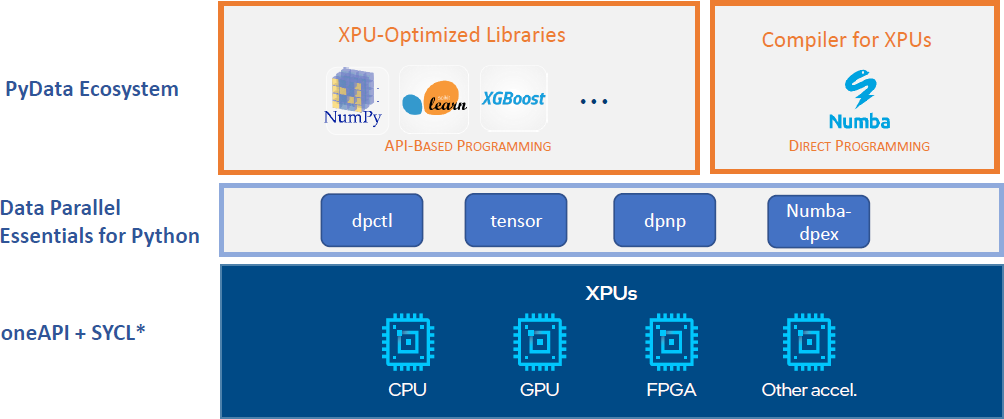



## Data Parallel Control-dpctl
* [dpctl](https://intelpython.github.io/dpctl/latest/index.html) es el mecanismo que dispone la [Intel® Distribution for Python](https://www.intel.com/content/www/us/en/developer/tools/oneapi/distribution-for-python.html) para interactuar con la administración de dispositivos SYCL
    * Se implementa mediante bloques *sycl_context("xpu")* que redirigen la ejecución a un dispositivo del tipo seleccionado: GPU, CPU o host
    * Los códigos que hacen uso de la librería [scikit-learn](https://scikit-learn.org) también se pueden ejecutar en dispositivos GPU
* Contenedor ligero de Python sobre un subconjunto de la API de DPC++/SYCL.
* dpctl está diseñado para proporcionar en tiempo de ejecución recursos SYCL específicos:
     * Wrapper para las principales funciones de la API de SYCL del runtime relacionadas con las clases *plataform*, *device*, *context*, *device_selector* y *queue*
     * Memoria USM
     
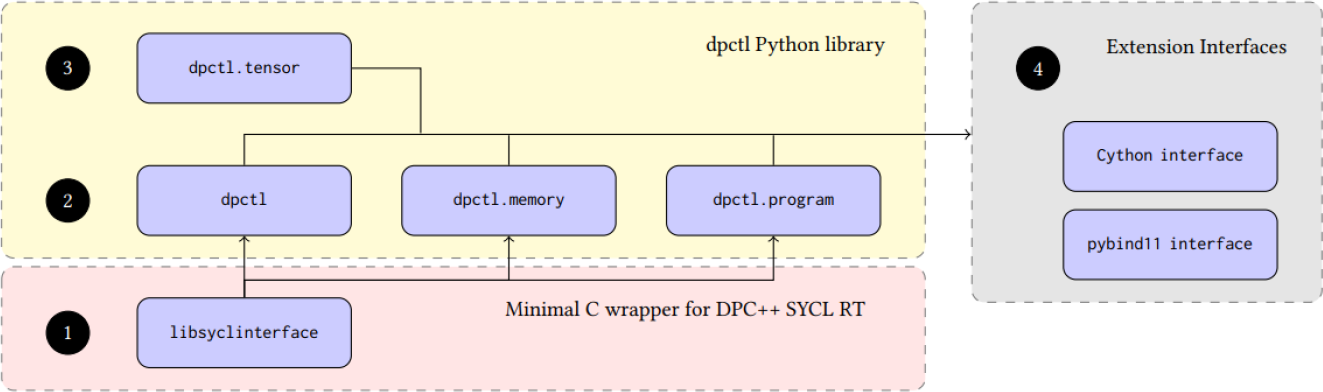

* Veamos como podemos obtener los dispositivos disponibles en nuestro sistema, mediante el siguiente código:
    1. Importamos la librería "Data Parallel Control"
    2. Seleccionamos el 

In [ ]:
from platform import python_version

print(python_version())

In [ ]:
import dpctl


print("dpctl.__version__ = ",dpctl.__version__)

d = dpctl.select_gpu_device()
d.print_device_info()

##  dpctl.tensors
* Vale la pena repetir esta información: para asegurarse de que el concepto sea claro
* La memoria de un acelerador es diferente a la memoria del host
* Cualquier operación que se desee hacer en el acelerador previamente hay que pasar los datos


In [ ]:
import numpy as np
import dpctl
import dpctl.tensor as dpt

x = np.array([1,2,3,4]) # Memory in host

x_device = dpt.from_numpy(x, usm_type = 'device', device = d) # Memory in device
x_host = dpt.to_numpy(x_device)

print(x_host)

# Scikit -learn con GPUs
* Para todos los algoritmos de la librería **sklearnex** es necesario que los datos estén almacenados en el dispositivos donde se desea ejecutar
* Los *dpctl tensor* permiten hacer el trasiego de información entre host y GPU

* Ejemplos: 
```
x_device = dpctl.tensor.asarray(X, usm_type = 'device', device = "gpu:0")
y_device = dpctl.tensor.asarray(y, usm_type = 'device', device = "gpu:0")
```

* Hay que prestar atención a la devolución y los tipos de datos de las funciones relacionadas con el entrenamiento:
   * **fit** en muchos casos en scikit-learn, la función *fit* devuelve un *selfobject*
   * **fit_predict** devuelve un *ndarray* que requiere ser transferido al host (to_numpy)
   * **predict** devuelve un *ndarray* que requiere ser transferido al host (to_numpy)
   * **fit_transform** devuelve un *ndarray* que requiere ser transferido al host (to_numpy)
   * **tranform** tipicamente devuelve un *ndarray* que requiere ser transferido al host (to_numpy)

* Rutinas de aprendizaje de Scikit que potencialmente devuelven objetos de tipo *ndarray* o que se pasen objetos de tipo *ndtype* como parámetro deberán convertirse a/desde numpy con la direccionabilidad from/to dpctl.tensor
   * Usar ```dpctl.tensor.from_numpy()``` para convertir pasar desde NumPy a *dpctl tensor*
   * Usar ```dpctl.tensor.to_numpy()``` para convertir desde *dpctl tensor* a NumPy

In [ ]:
import numpy as np

################################################################
#
# Import dptcl and patch here

import dpctl
print("dpctl.__version__ = ", dpctl.__version__)

from sklearnex import patch_sklearn
patch_sklearn()
#
################################################################

X = np.array([[1,  2], [1,  4], [1,  0],
              [10, 2], [10, 4], [10, 0]])

# You need to re-import scikit-learn algorithms after the patch
from sklearn.cluster import KMeans

device = dpctl.select_default_device()
print("Using device ...")
device.print_device_info()

x_device = dpctl.tensor.asarray(X,  device = device)
#x_device = dpctl.tensor.to_numpy(X,  device = device)

kmeans = KMeans(n_clusters=2, init='random', random_state=0).fit(x_device)
print(f"kmeans.labels_ = {kmeans.labels_}")

* En caso de utilizar el Intel DevCloud es altamente recomendable mandar el trabajo a un nodo con **GPU** para que se ejecute este dispositivo
* Para ello se realizarán los siguientes pasos:
    1. Crear un fichero python del tipo .py
    2. Lanzar trabajo que invoque al script python anterior

In [ ]:
%%writefile lab/scikit_kmeans.py
import numpy as np

################################################################
#
# Import dptcl and patch here

import dpctl
print("dpctl.__version__ = ", dpctl.__version__)

from sklearnex import patch_sklearn
patch_sklearn()
#
################################################################

X = np.array([[1,  2], [1,  4], [1,  0],
              [10, 2], [10, 4], [10, 0]])

# You need to re-import scikit-learn algorithms after the patch
from sklearn.cluster import KMeans

device = dpctl.select_default_device()
print("Using device ...")
device.print_device_info()

x_device = dpctl.tensor.asarray(X,  device = device)
#x_device = dpctl.tensor.to_numpy(X,  device = device)

kmeans = KMeans(n_clusters=2, init='random', random_state=0).fit(x_device)
print(f"kmeans.labels_ = {kmeans.labels_}")

In [ ]:
! chmod 755 q; chmod 755 run_kmeans_gpu.sh; if [ -x "$(command -v qsub)" ]; then ./q run_kmeans_gpu.sh; else ./run_kmeans_gpu.sh; fi